In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [3]:
data = pd.read_csv("/kaggle/input/health/prepocessed_hypothyroid.csv")

print(data.head())

print(data.info())

print(data.isnull().sum())

    age  sex  on thyroxine   TSH  T3 measured      T3    TT4  binaryClass
0  41.0  1.0             0  1.30            1  2.5000  125.0            0
1  23.0  1.0             0  4.10            1  2.0000  102.0            0
2  46.0  0.0             0  0.98            0  2.0135  109.0            0
3  70.0  1.0             1  0.16            1  1.9000  175.0            0
4  70.0  1.0             0  0.72            1  1.2000   61.0            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           3772 non-null   float64
 1   sex           3772 non-null   float64
 2   on thyroxine  3772 non-null   int64  
 3   TSH           3772 non-null   float64
 4   T3 measured   3772 non-null   int64  
 5   T3            3772 non-null   float64
 6   TT4           3772 non-null   float64
 7   binaryClass   3772 non-null   int64  
dtypes: float64(5), 

               age          sex  on thyroxine          TSH  T3 measured  \
count  3772.000000  3772.000000   3772.000000  3772.000000  3772.000000   
mean     51.735879     0.684705      0.123012     5.086766     0.796129   
std      20.082295     0.455362      0.328494    23.290853     0.402927   
min       1.000000     0.000000      0.000000     0.005000     0.000000   
25%      36.000000     0.000000      0.000000     0.600000     1.000000   
50%      54.000000     1.000000      0.000000     1.600000     1.000000   
75%      67.000000     1.000000      0.000000     3.800000     1.000000   
max     455.000000     1.000000      1.000000   530.000000     1.000000   

                T3          TT4  binaryClass  
count  3772.000000  3772.000000  3772.000000  
mean      2.013500   108.319345     0.077147  
std       0.738262    34.496511     0.266861  
min       0.050000     2.000000     0.000000  
25%       1.700000    89.000000     0.000000  
50%       2.013500   106.000000     0.0000

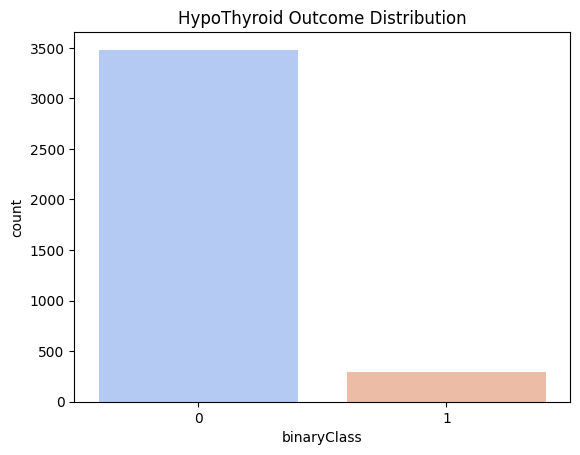

In [4]:
print(data.describe())

sns.countplot(x=data['binaryClass'], palette='coolwarm')
plt.title("HypoThyroid Outcome Distribution")
plt.show()

In [6]:
X = data.drop(columns=["binaryClass"])
y = data["binaryClass"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (3017, 7)
Testing Data Shape: (755, 7)


In [8]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'subsample': [0.6, 0.8, 1.0], 
    'colsample_bytree': [0.6, 0.8, 1.0], 
    'n_estimators': [100, 200, 300] 
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_xgb = xgb.XGBClassifier(**grid_search.best_params_, use_label_encoder=False, eval_metric="logloss")
best_xgb.fit(X_train, y_train)

y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

print("XGBoost Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("XGBoost Testing  Accuracy:", accuracy_score(y_test, y_pred_test))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_test))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 1.0}
XGBoost Training Accuracy: 0.9980112694729865
XGBoost Testing  Accuracy: 0.9947019867549669
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       697
           1       0.97      0.97      0.97        58

    accuracy                           0.99       755
   macro avg       0.98      0.98      0.98       755
weighted avg       0.99      0.99      0.99       755



In [9]:
param_grid2 = {
    'max_depth': [3, 5, 7],  
    'min_child_weight': [1, 3, 5],  
    'gamma': [0, 0.1, 0.3, 0.5], 
}

grid_search2 = GridSearchCV(
    estimator=xgb.XGBClassifier(
        colsample_bytree=1.0,
        learning_rate=0.01,
        n_estimators=200,
        subsample=0.6,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    param_grid=param_grid2,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search2.fit(X_train, y_train)

print("Best Parameters after second tuning:", grid_search2.best_params_)

best_xgb2 = xgb.XGBClassifier(**grid_search2.best_params_, 
                              colsample_bytree=1.0, 
                              learning_rate=0.01, 
                              n_estimators=200, 
                              subsample=0.6, 
                              use_label_encoder=False, 
                              eval_metric="logloss")

best_xgb2.fit(X_train, y_train)

y_pred_train2 = best_xgb2.predict(X_train)
y_pred_test2 = best_xgb2.predict(X_test)

print("XGBoost Training Accuracy (After Second Tuning):", accuracy_score(y_train, y_pred_train2))
print("XGBoost Testing Accuracy (After Second Tuning):", accuracy_score(y_test, y_pred_test2))
print("XGBoost Classification Report (After Second Tuning):\n", classification_report(y_test, y_pred_test2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters after second tuning: {'gamma': 0, 'max_depth': 3, 'min_child_weight': 1}
XGBoost Training Accuracy (After Second Tuning): 0.99171362280411
XGBoost Testing Accuracy (After Second Tuning): 0.9933774834437086
XGBoost Classification Report (After Second Tuning):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       697
           1       0.96      0.95      0.96        58

    accuracy                           0.99       755
   macro avg       0.98      0.97      0.98       755
weighted avg       0.99      0.99      0.99       755



In [10]:
import pickle
import joblib
import xgboost as xgb

with open("xgboost_hypothyroid_model.pkl", "wb") as file:
    pickle.dump(best_xgb2, file)

joblib.dump(best_xgb2, "xgboost_hypothyroid_model.joblib")

print("✅ Model saved successfully!")

✅ Model saved successfully!


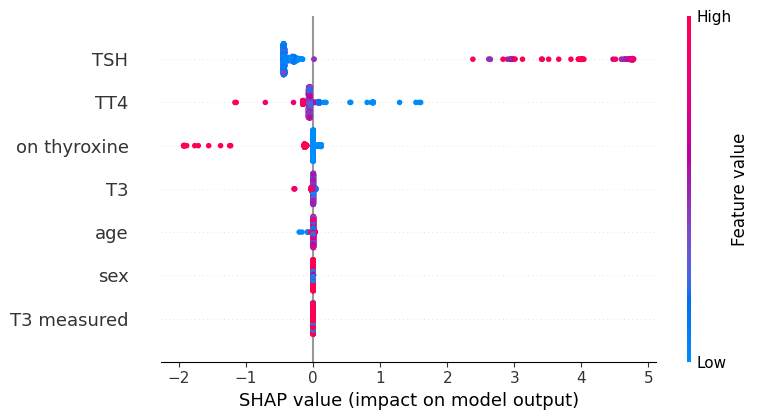

In [11]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(best_xgb2, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [12]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])

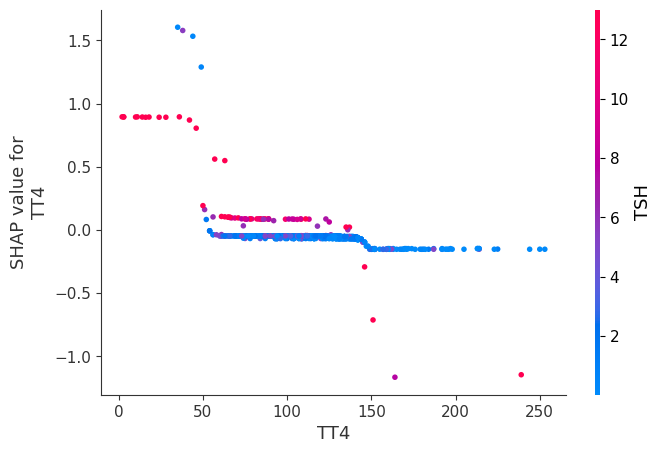

In [14]:
shap.dependence_plot("TT4", shap_values.values, X_test)